**BX-Users: It contains the information of users:**
- user_id - These have been anonymized and mapped to integers
- Location - Demographic data is provided
- Age - Demographic data is provided

**BX-Books:**
- isbn - Books are identified by their respective ISBNs. Invalid ISBNs have already been removed from the dataset.
- book_title
- book_author
- year_of_publication
- publisher

**BX-Book-Ratings: Contains the book rating information.**
- user_id
- isbn
- rating - Ratings (`Book-Rating`) are either explicit, expressed on a scale from 1–10 (higher values denoting higher appreciation), or implicit, expressed by 0.



In [222]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
user = pd.read_csv('data/BX-Users.csv',encoding='ISO-8859-1',low_memory=False)
book = pd.read_csv('data/BX-Books.csv',encoding='ISO-8859-1',low_memory=False)
rating = pd.read_csv('data/BX-Book-Ratings.csv',encoding='ISO-8859-1')

# check for duplicates

In [16]:
user.duplicated().sum()

0

In [17]:
book.duplicated().sum()

0

In [21]:
# it is normal to have multiple ratings for a book
rating.duplicated().sum()

146

In [9]:
print('Users dataset shape: ',user.shape)
print('Books dataset shape: ',book.shape)
print('Ratings dataset shape: ',rating.shape)

Users dataset shape:  (278859, 3)
Books dataset shape:  (271379, 5)
Ratings dataset shape:  (1048575, 3)


1) Explore the books dataset

In [10]:
book.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [11]:
book.head().isna().sum() # check missing values

isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
dtype: int64

In [12]:
rating.head()

,user_id,isbn,rating
0,276725,034545104X,0
1,276726,155061224,5
2,276727,446520802,0
3,276729,052165615X,3
4,276729,521795028,6


check for missing values

In [13]:
rating.isna().sum()

user_id    0
isbn       0
rating     0
dtype: int64

3) Take a quick look at the number of unique users and books

In [14]:
print(f"There are {len(rating['user_id'].unique())} number of unique Users")
print(f"There are {len(rating['isbn'].unique())} number of unique Books")

There are 95513 number of unique Users
There are 322102 number of unique Books


4) Convert ISBN variables to numeric numbers in the correct order
5) Convert ISBN variables to numeric numbers in the correct order
6) Convert the user_id variable to numeric numbers in the correct order
7) Convert both user_id and ISBN to the ordered list, i.e., from 0...n-1

In [15]:
lb = LabelEncoder()
rating['isbn_number'] = lb.fit_transform(rating['isbn'])
rating['user_id_number'] = lb.fit_transform(rating['user_id'])
rating.head()

,user_id,isbn,rating,isbn_number,user_id_number
0,276725,034545104X,0,4511,94663
1,276726,155061224,5,30815,94664
2,276727,446520802,0,158458,94665
3,276729,052165615X,3,9704,94666
4,276729,521795028,6,177084,94666


*adding the book title to the book_rating dataframe*

In [41]:
book_rating_with_title = pd.merge(rating,book,how='inner',on='isbn')
book_rating_with_title.head(3)

,user_id,isbn,rating,isbn_number,user_id_number,book_title,book_author,year_of_publication,publisher
0,276725,034545104X,0,4511,94663,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,2313,034545104X,5,4511,805,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
2,6543,034545104X,0,4511,2372,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books


*group the dataframe by book names to calculate the total number of people who have rated each book and the mean rating for each book*

In [57]:
book_rating_count = book_rating_with_title.groupby('book_title').agg({'isbn':'count', 'rating': 'mean'})\
                                                                                .reset_index()
book_rating_count.sort_values(by='isbn',ascending=False,inplace=True)
book_rating_count.rename(columns={'isbn':'no_of_rating','rating':'avg_rating'},inplace=True)
book_rating_count.head()

,book_title,no_of_rating,avg_rating
224408,Wild Animus,2264,1.032244
187425,The Lovely Bones: A Novel,1164,4.457045
175245,The Da Vinci Code,828,4.679952
5092,A Painted House,766,3.199739
190219,The Nanny Diaries: A Novel,759,3.459816


*plot of books with highest number of rating in decending order only books with rating count greater than 100*

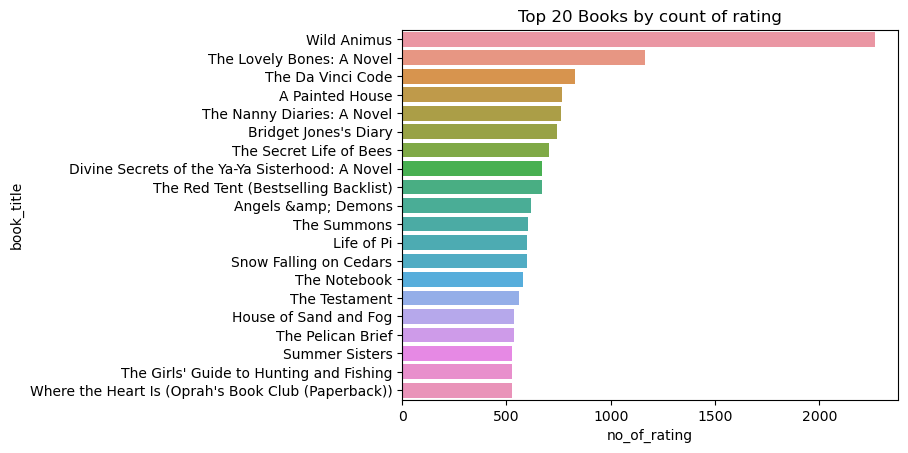

In [558]:
popular_books = book_rating_count[book_rating_count['no_of_rating']>100]
sns.barplot(data=popular_books[:20], y='book_title',x='no_of_rating')
plt.title('Top 20 Books by count of rating')
plt.show()

# **Implementation of Item-based collaborative filtering**

1)  filtering out books that have been rated by less than 50 people and users with less than 100 rating 

In [559]:
user_filter = book_rating_with_title.groupby('user_id').count()['rating'] >= 100
x = book_rating_with_title[book_rating_with_title['user_id'].isin(user_filter[user_filter].index)]
book_filter = x.groupby('book_title').count()['rating']>=50
filtered_data = x[x['book_title'].isin(book_filter[book_filter].index)]

In [560]:
item_based = filtered_data.pivot_table(index='book_title',columns='user_id_number',values='rating').fillna(0)
item_based.head()

user_id_number,95,177,294,490,494,600,650,700,732,791,...,94556,94615,94638,94662,94918,94936,94998,95227,95250,95341
book_title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010: Odyssey Two,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [561]:
item_similarity = cosine_similarity(item_based)

# Item Based Recoomender

In [577]:
def item_based_recommend(book_name):
    index = np.where(item_based.index==book_name)[0][0]
    distance = item_similarity[index]
    similar_items = sorted(list(enumerate(distance)),key = lambda x : x[1], reverse = True)[1:10]
    print(f"Getting Similar Books to '{book_name}'...")
    print('===========================')
    for i in similar_items:
        print(item_based.index[i[0]])
    print("""
          """)

In [578]:
for book_name in item_based.index[:20]:
    item_based_recommend(book_name)

Getting Similar Books to '1984'...
Animal Farm
Slaughterhouse Five or the Children's Crusade: A Duty Dance With Death
Brave New World
Awakening
Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players
The Vampire Lestat (Vampire Chronicles, Book II)
The Catcher in the Rye
Timeline
The Hitchhiker's Guide to the Galaxy

          
Getting Similar Books to '1st to Die: A Novel'...
Along Came a Spider (Alex Cross Novels)
Kiss the Girls
Cradle and All
Tell Me Your Dreams
2nd Chance
Silent Night : A Christmas Suspense Story
Pop Goes the Weasel
All Around the Town
Cat &amp; Mouse (Alex Cross Novels)

          
Getting Similar Books to '2010: Odyssey Two'...
Dune Messiah (Dune Chronicles, Book 2)
The Talisman
The Girl Who Loved Tom Gordon
Dream Country
A Separate Peace
Forever... : A Novel of Good and Evil, Love and Hope
The Hitchhiker's Guide to the Galaxy
Crossings
Daisy Fay and the Miracle Man

          
Getting Similar Books to '2nd Chance'...
F

# **Implementing the User Based Collaborative filtering**

In [563]:
user_based = filtered_data.pivot_table(index='user_id_number',columns='book_title',values='rating').fillna(0)
user_based.head()

book_title,1984,1st to Die: A Novel,2010: Odyssey Two,2nd Chance,4 Blondes,84 Charing Cross Road,A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)),A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,A Bend in the Road,A Case of Need,...,Without Remorse,"Wizard and Glass (The Dark Tower, Book 4)",Women Who Run with the Wolves,"Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players",Wuthering Heights,Year of Wonders,You Belong To Me,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zoya,"\O\"" Is for Outlaw"""
user_id_number,,,,,,,,,,,,,,,,,,,,,
95,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0
494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [564]:
user_similarity =  cosine_similarity(user_based)

**User Based Recommender**

In [582]:
def user_based_recommendations(user_id):
    index = np.where(user_based.index==user_id)[0][0]
    user_watched_movie = user_based.iloc[index].sort_values(ascending=False)[:20].index
    distance = user_similarity[index]
    similar_users = sorted(list(enumerate(distance)),key = lambda x : x[1], reverse = True)[1:10]
    print(f"Getting Recommendations for 'user {user_id}'")
    print('===========================')
    to_recommend = {}
    for user_index , similarity in similar_users:
        # filter users with less than 0.2 similarity score
        if similarity < 0.2:
            continue
        else:
            target = user_based.iloc[user_index].sort_values(ascending=False)[:10] 
            target_profile = list(zip(target.values,target.index))
            for rating , movie in target_profile:
                # filter movies that similar users have given a rating below 5
                if rating < 5:
                    continue
                else:
                    if movie in user_watched_movie:
                        continue
                    else:
                        if movie in to_recommend.keys():
                            to_recommend[movie] += 1
                        else:
                            to_recommend[movie] = 1
    to_recommend = [key for key, value in sorted(to_recommend.items(), key = lambda x : x[1],reverse = True)][:10]
    for books in to_recommend:
        print(books)
    print("""
          """)

In [583]:
for i in user_based.index[:20]:
    user_based_recommendations(user_id = i)

Getting Recommendations for 'user 95'
Harry Potter and the Order of the Phoenix (Book 5)
Don't Sweat the Small Stuff and It's All Small Stuff : Simple Ways to Keep the Little Things from Taking Over Your Life (Don't Sweat the Small Stuff Series)
How to Make an American Quilt
The Hobbit : The Enchanting Prelude to The Lord of the Rings
The Great Gatsby
The Tao of Pooh
When the Wind Blows
Beloved (Plume Contemporary Fiction)
Couplehood
Key of Light (Key Trilogy (Paperback))

          
Getting Recommendations for 'user 177'
Summer Sisters
Confessions of an Ugly Stepsister : A Novel
The Cat Who Tailed a Thief
Sisterhood of the Traveling Pants
Prodigal Summer: A Novel
Ender's Game (Ender Wiggins Saga (Paperback))
To Kill a Mockingbird
The Giver (21st Century Reference)
The Bean Trees
A Wrinkle In Time

          
Getting Recommendations for 'user 294'
Heartbreaker
Mystic River
Atonement : A Novel
Like Water for Chocolate: A Novel in Monthly Installments, With Recipes, Romances, and Home Re